In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [ ]:
ANNOTATIONS_FILE = "FILEPATH"
CLASSES_FILE     = "FILEPATH"
TRAIN_DIR        = "FILEPATH"

In [ ]:
def create_data(annotations_file):
    data = []
    with open(annotations_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            img_file = parts[0]
            for box_str in parts[1:]:
                x_min, y_min, x_max, y_max, class_id = map(int, box_str.split(','))
                data.append([img_file, x_min, y_min, x_max, y_max, class_id])
    return pd.DataFrame(data, columns=['image_path','x_min','y_min','x_max','y_max','class_id'])


In [ ]:
def load_classes(classes_file):
    class_map = {}
    with open(classes_file, 'r') as f:
        for idx, line in enumerate(f):
            class_map[idx] = line.strip()
    return class_map

In [ ]:

def load_and_preprocess_image(img_path, x_min, y_min, x_max, y_max, class_id, base_dir):
    path = tf.strings.join([base_dir, os.sep, img_path])
    raw = tf.io.read_file(path)
    img = tf.image.decode_jpeg(raw, channels=3)


    offset_height = tf.cast(y_min, tf.int32)
    offset_width = tf.cast(x_min, tf.int32)
    target_height = tf.cast(y_max - y_min, tf.int32)
    target_width = tf.cast(x_max - x_min, tf.int32)

    cropped = tf.image.crop_to_bounding_box(
        img,
        offset_height=offset_height,
        offset_width=offset_width,
        target_height=target_height,
        target_width=target_width
    )
    cropped = tf.image.resize(cropped, [128, 128]) / 255.0
    return cropped, class_id

In [ ]:
def make_dataset(df, base_dir, batch_size=32):
    paths = df['image_path'].values
    x_mins = df['x_min'].values
    y_mins = df['y_min'].values
    x_maxs = df['x_max'].values
    y_maxs = df['y_max'].values
    labels = df['class_id'].values

    ds = tf.data.Dataset.from_tensor_slices((paths, x_mins, y_mins, x_maxs, y_maxs, labels))
    ds = ds.map(
        lambda p, xm, ym, xM, yM, lbl: load_and_preprocess_image(p, xm, ym, xM, yM, lbl, base_dir),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [ ]:
df = create_data(ANNOTATIONS_FILE)
class_map = load_classes(CLASSES_FILE)

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['class_id'], random_state=42)
train_ds = make_dataset(train_df, TRAIN_DIR, batch_size=32)
val_ds   = make_dataset(val_df,   TRAIN_DIR, batch_size=32)

In [ ]:
num_classes = len(class_map)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [ ]:

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
367/367 ━━━━━━━━━━━━━━━━━━━━ 193s 518ms/step - accuracy: 0.6138 - loss: 1.4604 - val_accuracy: 0.9571 - val_loss: 0.1647
Epoch 2/3
367/367 ━━━━━━━━━━━━━━━━━━━━ 345s 941ms/step - accuracy: 0.9678 - loss: 0.1256 - val_accuracy: 0.9683 - val_loss: 0.1152
Epoch 3/3
367/367 ━━━━━━━━━━━━━━━━━━━━ 138s 376ms/step - accuracy: 0.9858 - loss: 0.0485 - val_accuracy: 0.9683 - val_loss: 0.1303


In [ ]:
def draw_bounding_boxes(image, bbox, pred_label, true_label, color=(255, 0, 0)):
    x_min, y_min, x_max, y_max = bbox
    image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
    text = f"Pred: {pred_label} | True: {true_label}"
    image = cv2.putText(image, text, (x_min, y_min - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
    return image

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step


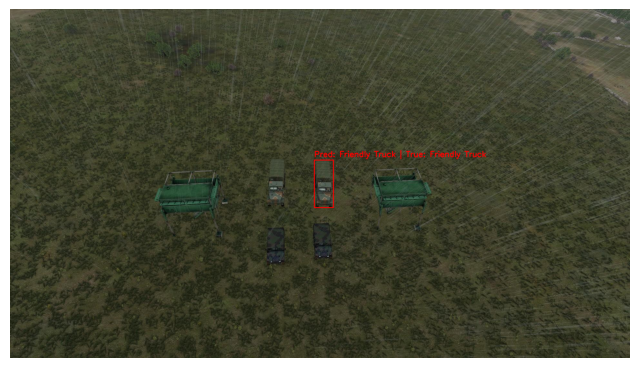

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


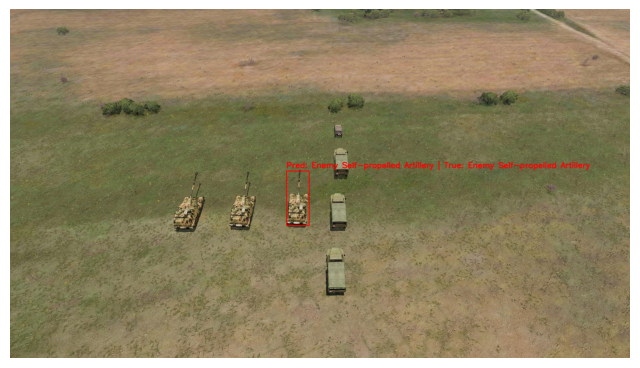

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


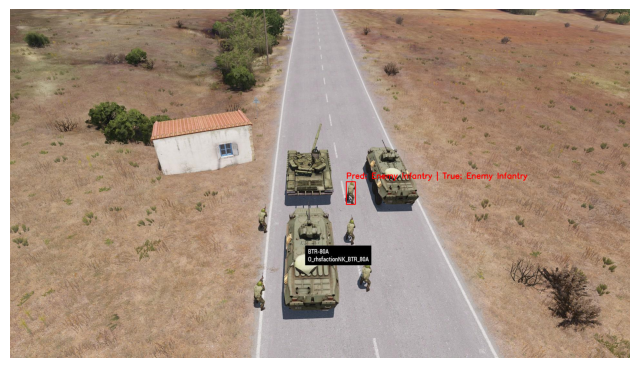

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


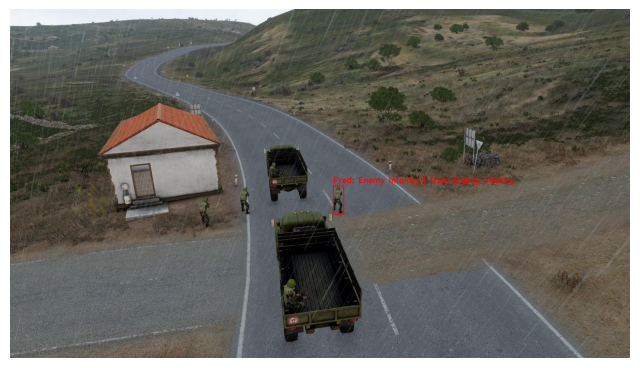

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


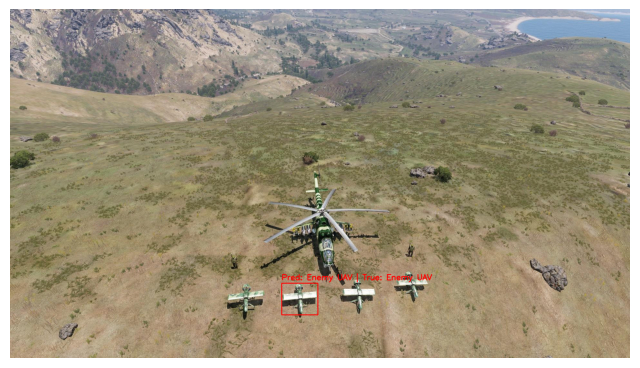

In [ ]:



for i in range(5): 

    sample = val_df.iloc[i]
    
    img_path = os.path.join(TRAIN_DIR, sample["image_path"])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    bbox = [
        int(sample["x_min"]),
        int(sample["y_min"]),
        int(sample["x_max"]),
        int(sample["y_max"])
    ]
    true_class_id = sample["class_id"]
    true_class_name = class_map[true_class_id]
    
    cropped_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]  
    resized_img = cv2.resize(cropped_img, (128, 128)) / 255.0
    resized_img = np.expand_dims(resized_img, axis=0)  
    pred_class_id = np.argmax(model.predict(resized_img))
    pred_class_name = class_map[pred_class_id]
    
    annotated_img = draw_bounding_boxes(img.copy(), bbox,
                                        pred_label=pred_class_name,
                                        true_label=true_class_name)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(annotated_img)
    plt.axis("off")
    plt.show()


In [ ]:
img_path =r"IMAGE PATH"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

bbox = [
    int(sample["x_min"]),
    int(sample["y_min"]),
    int(sample["x_max"]),
    int(sample["y_max"])
]
true_class_id = sample["class_id"]
true_class_name = class_map[true_class_id]

cropped_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]  
resized_img = cv2.resize(cropped_img, (128, 128)) / 255.0
resized_img = np.expand_dims(resized_img, axis=0)  
pred_class_id = np.argmax(model.predict(resized_img))
pred_class_name = class_map[pred_class_id]

annotated_img = draw_bounding_boxes(img.copy(), bbox,
                                    pred_label=pred_class_name,
                                    true_label=true_class_name)

plt.figure(figsize=(8, 8))
plt.imshow(annotated_img)
plt.axis("off")
plt.show()


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (84903434.py, line 1)